In [1]:
import torch
import scipy
import keras
from keras.preprocessing.image import (
    random_rotation, random_shift, random_shear, random_zoom,
    random_channel_shift, transform_matrix_offset_center, img_to_array)

C:\Users\VuDinhPhong\Anaconda3\envs\YOLO-env\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from collections import Counter

In [3]:
TRAINING_IMG_FOLDER = os.path.join(os.getcwd(), 'train')
RESIZE_WIDTH = 256
RESIZE_HEIGH = 256

In [4]:
train_csv = pd.read_csv('train.csv')
train_csv.head()

,Image,Id
0,00022e1a.jpg,w_e15442c
1,000466c4.jpg,w_1287fbc
2,00087b01.jpg,w_da2efe0
3,001296d5.jpg,w_19e5482
4,0014cfdf.jpg,w_f22f3e3


In [5]:
def load_imgs_from_folder(folder, filenames=None):
    imgs = []
    file_names = filenames if filenames is not None else train_csv.Image
    for f in file_names:
        img = cv2.imread(os.path.join(folder, f))
        img = cv2.resize(img, (RESIZE_WIDTH, RESIZE_HEIGH))
        imgs.append(img)
    return imgs
    

In [6]:
random_imgs_name = train_csv.sample(frac=0.3)
imgs = load_imgs_from_folder(TRAINING_IMG_FOLDER, random_imgs_name.Image)

(256, 256, 3)


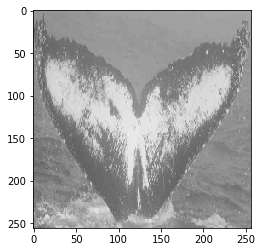

In [7]:
plt.imshow(imgs[0])
print(imgs[0].shape)

In [8]:
def plot_imgs(imgs_set, imgs_name=None):
    
    fig = plt.figure(figsize=(15,15))
    if imgs_name is None:
        imgs_name = np.arange(len(imgs_set))
        
    COL = 5
    ROW = (len(imgs_set)/COL) + 1
    for i,im in enumerate(imgs_set):
        
        ax = fig.add_subplot(ROW,COL,i+1)
        
        ax.set_title(imgs_name[i])
        ax.imshow(im, cmap='gray')
        

    

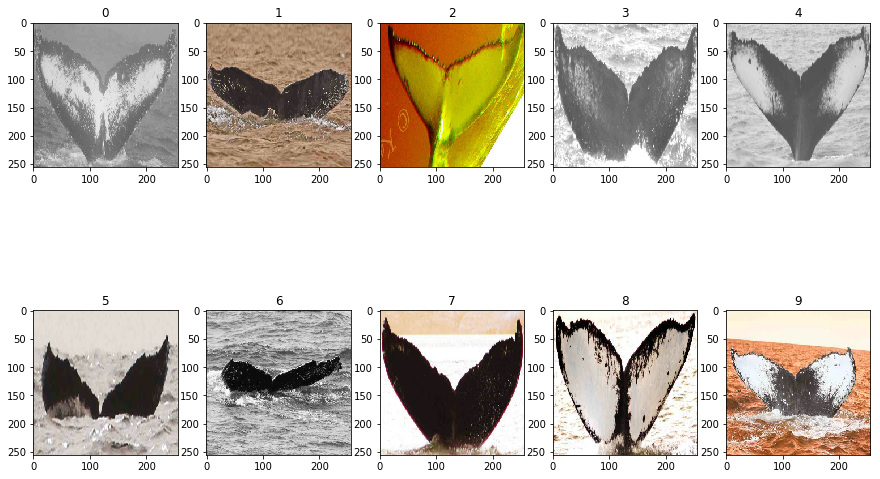

In [9]:
plot_imgs(imgs[:10])

In [10]:
def data_argumentation_pipeline(img):
    
    def rgb2gray(rgb):
        if np.random.rand() < 0.5:
            return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])*255
        return rgb
    
    img = random_rotation(img,rg=25, row_axis=0, col_axis=1, channel_axis=2, fill_mode='nearest')
    
    img = random_shift(img, wrg=0.2, hrg=0.2, row_axis=0, col_axis=1, channel_axis=2, fill_mode='nearest', cval=0.0 )
    
    img = rgb2gray(img)

    return img

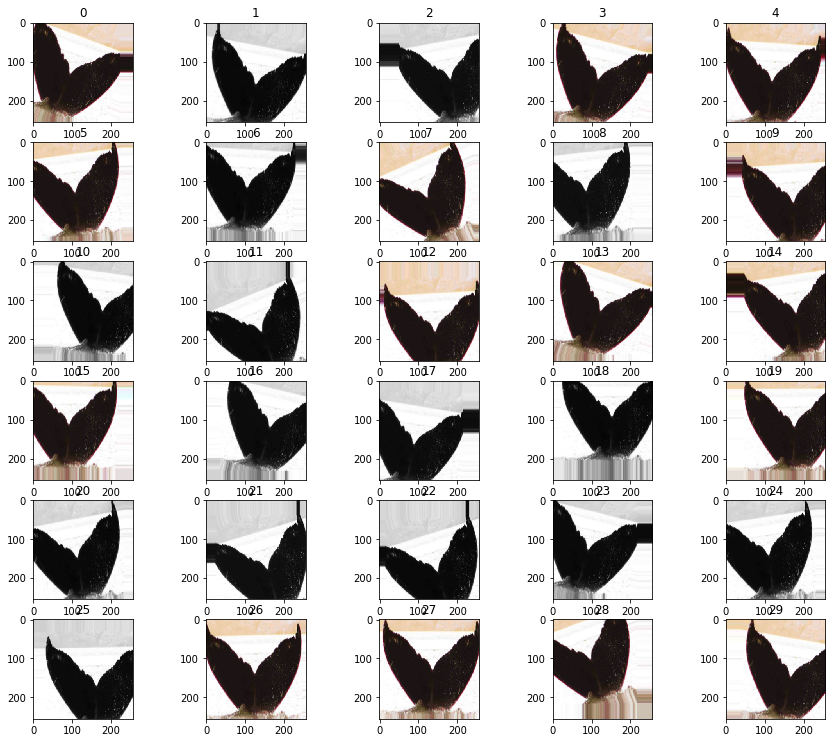

In [11]:

plot_imgs([data_argumentation_pipeline(imgs[7]) for _ in range(30)])

In [40]:
images_per_label = train_csv.groupby('Id').filter(lambda x: len(x) <= 10)

In [41]:
images_per_label

,Image,Id
0,00022e1a.jpg,w_e15442c
3,001296d5.jpg,w_19e5482
4,0014cfdf.jpg,w_f22f3e3
5,0025e8c2.jpg,w_8b1ca89
6,0026a8ab.jpg,w_eaad6a8
8,0035632e.jpg,w_3d0bc7a
9,0037e7d3.jpg,w_50db782
10,00389cd7.jpg,w_2863d51
11,0042dcc4.jpg,w_6dc7db6
12,0042ea34.jpg,w_968f2ca


In [ ]:
print(Counter(images_per_label.Image))